In [1]:
from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
import astropy.units as u
from astropy.time import Time
import schwimmbad
import matplotlib.pyplot as plt
import numpy as np

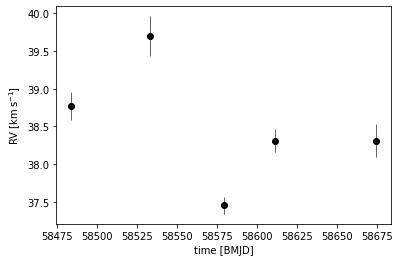

In [2]:
t0 = Time('2019-01-01T00:00:00')
t = [0., 49.452, 95.393, 127.587, 190.408] + t0
rv = [38.77, 39.70, 37.45, 38.31, 38.31] * u.km/u.s
err = [0.184, 0.261, 0.112, 0.155, 0.223] * u.km/u.s
data = RVData(t=t, rv=rv, stddev=err)
ax = data.plot() # doctest: +SKIP
# ax.set_xlim(-10, 200) # doctest: +SKIP

In [3]:
params = JokerParams(P_min=8*u.day, P_max=512*u.day)

In [4]:
joker = TheJoker(params)
samples = joker.rejection_sample(data, n_prior_samples=65536) # doctest: +SKIP

INFO: 58 good samples after rejection sampling [thejoker.sampler.sampler]


(58483.0, 58675.408)

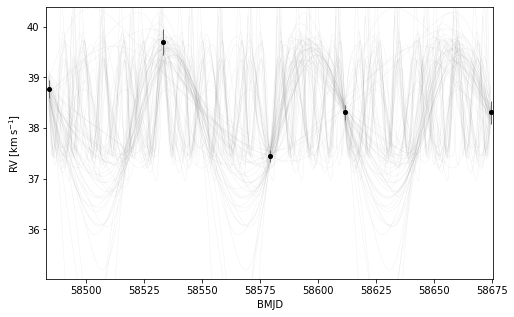

In [5]:

# fig, ax = plt.subplots(1, 1, figsize=(6,6)) # doctest: +SKIP
# ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
#            marker='.', color='k', alpha=0.45) # doctest: +SKIP
# ax.set_xlabel("$P$ [day]")
# ax.set_ylabel("$K$ [km/s]")
# ax.set_xlim(-5, 128)
# ax.set_ylim(0.75, 3.)

# ax.scatter(61.942, 1.3959, marker='o', color='#31a354', zorder=-100)

fig, ax = plt.subplots(1, 1, figsize=(8,5)) # doctest: +SKIP
t_grid = np.linspace(min(t.mjd),max(t.mjd), 1024)
_ = plot_rv_curves(samples, t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='#888888'))
ax.set_xlim(min(t.mjd)-1, max(t.mjd)+1)

# Add Astroplan

In [6]:
from astropy.coordinates import SkyCoord
from astroplan import FixedTarget


In [7]:
prae = FixedTarget.from_name('M44')


In [8]:
from astroplan import Observer
observer = Observer.at_site('flwo')

In [68]:
time_range = Time(["2019-12-01 06:00", "2019-12-01 18:00"])

In [100]:
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint)
constraints = [AltitudeConstraint(40*u.deg, 95*u.deg),
               AirmassConstraint(2), AtNightConstraint.twilight_civil()]

In [101]:
from astroplan import is_observable, is_always_observable, months_observable
# Are targets *ever* observable in the time range?
ever_observable = is_observable(constraints, observer, [prae], time_range=time_range)

# Are targets *always* observable in the time range?
always_observable = is_always_observable(constraints, observer, [prae],  time_range=time_range)

# During what months are the targets ever observable?
best_months = months_observable(constraints, observer, [prae])

In [102]:
print(ever_observable,always_observable,best_months)

[ True] [False] [{1, 2, 3, 4, 5, 6, 9, 10, 11, 12}]


In [103]:

from astroplan import (FixedTarget, Observer, AltitudeConstraint,
                       AtNightConstraint, MoonSeparationConstraint)
from astroplan.utils import time_grid_from_range


In [104]:
time_grid = time_grid_from_range(time_range,
                                 time_resolution=1*u.hour)

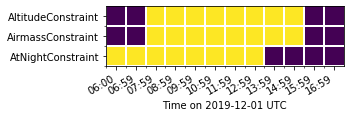

In [106]:
observability_grid = np.zeros((len(constraints), len(time_grid)))

for i, constraint in enumerate(constraints):
    # Evaluate each constraint
    observability_grid[i, :] = constraint(observer,prae, times=time_grid)

# Create plot showing observability of the target:

extent = [-0.5, -0.5+len(time_grid), -0.5, 2.5]

fig, ax = plt.subplots()
ax.imshow(observability_grid, extent=extent)

ax.set_yticks(range(0, 3)[::-1])
ax.set_yticklabels([c.__class__.__name__ for c in constraints])

ax.set_xticks(range(len(time_grid)))
ax.set_xticklabels([t.datetime.strftime("%H:%M") for t in time_grid])

ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.tick_params(axis='x', which='minor', bottom='off')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

ax.tick_params(axis='y', which='minor', left='off')
ax.set_xlabel('Time on {0} UTC'.format(time_grid[0].datetime.date()))
fig.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.1)
plt.show()

In [116]:
from astroplan import Constraint, is_observable, min_best_rescale
from astropy.coordinates import Angle
import astropy.units as u

class RVDispersionConstraint(Constraint):
    """
    Observe the star when the dispersion in possible orbits is highest.
    """
    def __init__(self, samples, min=None, max=None,rv_unit=u.km/u.s, 
                 max_samp=200,boolean_constraint=True
                 ):
        """
        samples: samples output by TheJoker
    
        min : `~astropy.units.Quantity` or `None` (optional)
            Minimum acceptable model dispersion for observation. `None`
            indicates no limit.
        max : `~astropy.units.Quantity` or `None` (optional)
            Maximum acceptable model dispersion for observation. `None`
            indicates no limit.
        """
        if len(samples)>max_samp:
            self.samples = samples[:max_samp]
        else:
            self.samples = samples
            
        self.rv_unit = rv_unit
        self.n_samp = len(samples)

        self.min = min if min is not None else 0.5*self.rv_unit
        self.max = max if max is not None else 1000*self.rv_unit
        self.boolean_constraint = boolean_constraint

    def compute_constraint(self, times, observer=None, targets=None):
        """
        times: astropy Time grid
        
        """
        
        model_rv = np.zeros((self.n_samp, len(times)))
        for i in range(self.n_samp):
            orbit = self.samples.get_orbit(i)
            model_rv[i] = orbit.radial_velocity(times).to(self.rv_unit).value
        
        model_dispersion = model_rv.std(axis=0)*self.rv_unit

        if self.boolean_constraint:
            print(self.min)
            print(model_dispersion)
            mask = ((self.min < model_dispersion) & (model_dispersion < self.max))
            return mask

        # if we want to return a non-boolean score
        else:
            # rescale the vega_separation values so that they become
            # scores between zero and one
            min_disp = np.percentile(model_disperion,75)
            rescale = min_best_rescale(model_dispersion, min_disp,
                                       self.max, less_than_min=0)
            return rescale

In [117]:

constraints = [AltitudeConstraint(40*u.deg, 90*u.deg),
               AirmassConstraint(2), AtNightConstraint.twilight_civil(),
              RVDispersionConstraint(samples,1.25*u.km/u.s, 1.5*u.km/u.s)]

In [118]:
# Are targets *ever* observable in the time range?
ever_observable = is_observable(constraints, observer, [prae], time_range=time_range)

# Are targets *always* observable in the time range?
always_observable = is_always_observable(constraints, observer, [prae],  time_range=time_range)

# During what months are the targets ever observable?
best_months = months_observable(constraints, observer, [prae])

1.25 km / s
[1.3645032  1.36411804 1.36377055 1.36346215 1.36319421 1.36296806
 1.36278498 1.36264618 1.36255279 1.36250584 1.36250625 1.36255485
 1.36265232 1.36279923 1.362996   1.3632429  1.36354007 1.3638875
 1.36428504 1.36473237 1.36522906 1.36577453 1.36636806 1.36700883] km / s
1.25 km / s
[1.3645032  1.36411804 1.36377055 1.36346215 1.36319421 1.36296806
 1.36278498 1.36264618 1.36255279 1.36250584 1.36250625 1.36255485
 1.36265232 1.36279923 1.362996   1.3632429  1.36354007 1.3638875
 1.36428504 1.36473237 1.36522906 1.36577453 1.36636806 1.36700883] km / s
1.25 km / s
[1.00113034 1.00247237 1.00390057 ... 1.27366216 1.2731277  1.27259058] km / s


1.25 km / s
[1.3645032  1.36377055 1.36319421 1.36278498 1.36255279 1.36250625
 1.36265232 1.362996   1.36354007 1.36428504 1.36522906 1.36636806] km / s


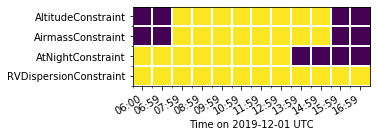

In [119]:
observability_grid = np.zeros((len(constraints), len(time_grid)))

for i, constraint in enumerate(constraints):
    # Evaluate each constraint
    observability_grid[i, :] = constraint(observer,prae, times=time_grid)

# Create plot showing observability of the target:

extent = [-0.5, -0.5+len(time_grid), -0.5, 3.5]

fig, ax = plt.subplots()
ax.imshow(observability_grid, extent=extent)

ax.set_yticks(range(0, len(constraints))[::-1])
ax.set_yticklabels([c.__class__.__name__ for c in constraints])

ax.set_xticks(range(len(time_grid)))
ax.set_xticklabels([t.datetime.strftime("%H:%M") for t in time_grid])

ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.tick_params(axis='x', which='minor', bottom='off')
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

ax.tick_params(axis='y', which='minor', left='off')
ax.set_xlabel('Time on {0} UTC'.format(time_grid[0].datetime.date()))
fig.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.1)
plt.show()

In [87]:
observability_grid

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])